In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.io
import shutil

In [2]:
def load_filelist():
    FILELIST = []
    # nasa battery dataset dir
    data_directory = "../BatteryAgingARC-FY08Q4"
    
    if os.path.exists(data_directory):
        for dirname, _, filenames in os.walk(data_directory):
            for filename in filenames:
                filepath = os.path.join(dirname, filename)
                FILELIST.append(filepath)
                print(f"Found: {filepath}")
    else:
        print(f"ERROR: '{data_directory}' directory not found!")
        print("Current working directory:", os.getcwd())
        print("Contents of current directory:", os.listdir('.'))
    
    return FILELIST
            
def filter_matfiles_list(filelist):
    filelist = [filepath for filepath in filelist if filepath.endswith('.mat')]
    filelist = [filepath for filepath in filelist if "BatteryAgingARC_25_26_27_28_P1" not in filepath]
    return filelist

def loadmat(filepath):
    return scipy.io.loadmat(filepath, simplify_cells=True)

In [3]:
FILELIST = filter_matfiles_list(load_filelist())

Found: ../BatteryAgingARC-FY08Q4\BatteryAgingARC-FY08Q4\B0005.mat
Found: ../BatteryAgingARC-FY08Q4\BatteryAgingARC-FY08Q4\B0006.mat
Found: ../BatteryAgingARC-FY08Q4\BatteryAgingARC-FY08Q4\B0018.mat


In [4]:
mat = loadmat("../BatteryAgingARC-FY08Q4/BatteryAgingARC-FY08Q4/B0005.mat")

In [5]:
df = pd.DataFrame(data=mat['B0005']['cycle'][0]['data'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      789 non-null    float64
 1   Current_measured      789 non-null    float64
 2   Temperature_measured  789 non-null    float64
 3   Current_charge        789 non-null    float64
 4   Voltage_charge        789 non-null    float64
 5   Time                  789 non-null    float64
dtypes: float64(6)
memory usage: 37.1 KB


In [7]:
def plot_test_data(df, profile="charge"):
    
    if profile=='charge':
        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_charge, 'b', label='Voltage_charge')
        plt.plot(df.Time, df.Current_charge, 'r', label='Current_charge')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile=='discharge':
        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_load, 'b', label='Voltage_load')
        plt.plot(df.Time, df.Current_load, 'r', label='Current_load')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile=='impedance':
        pass
    else:
        print('No cycle recognized')

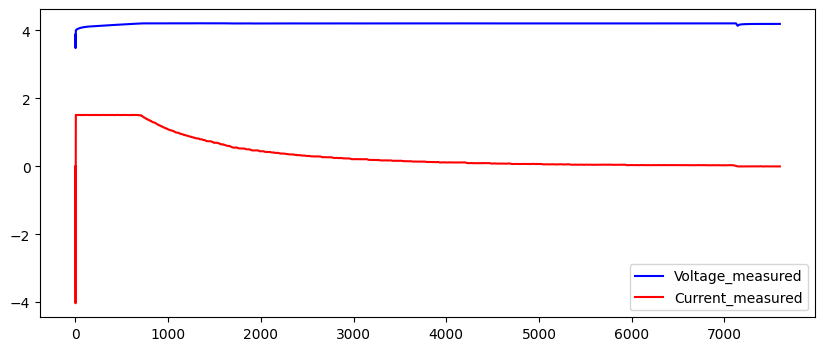

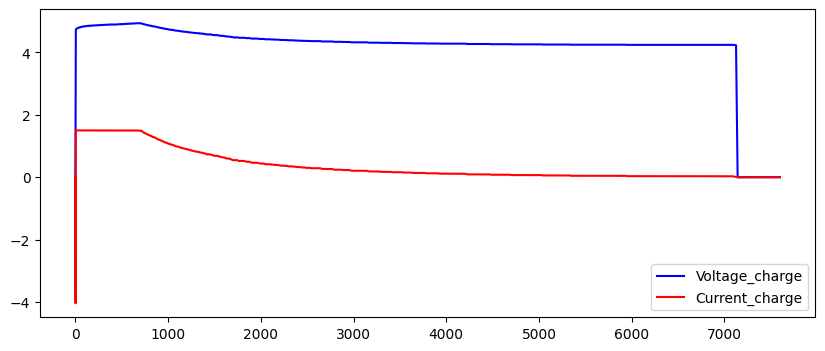

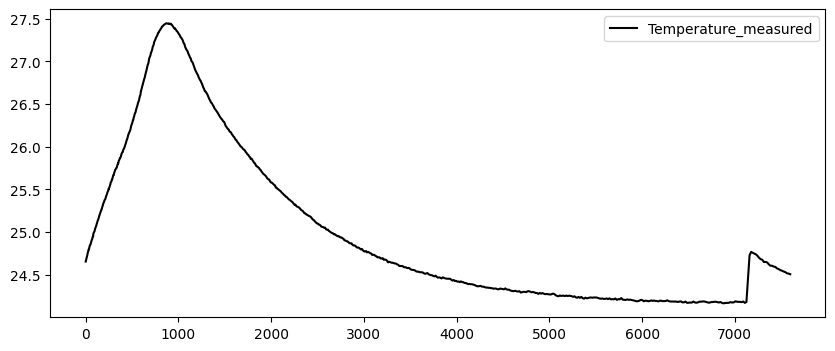

In [8]:
plot_test_data(df)

In [9]:
df = pd.DataFrame(data=mat['B0005']['cycle'][1]['data'])
df.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487


In [10]:
def process_data_dict(data_dict):
    """
    - ndict: new dictionary with the test data to build a corresponding dataframe
    - metadata_dict: anything that doesn't fit in ndict ('Capacity' is just a float)
    """
    
    ndict = {}
    metadata_dict = {}
    for k, v in data_dict.items():
        if k not in ['Capacity', 'Re', 'Rct']:
            ndict[k]=v
        elif k == 'Capacity':
            metadata_dict[k]=v
        elif k == 'Re':
            metadata_dict[k]=v
        elif k == 'Rct':
            metadata_dict[k]=v
        else:
            print("Exception")
    
    return ndict, metadata_dict


def fill_metadata_row(metadata, test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct):
    new_row = pd.DataFrame({
        'type': [test_type],
        'start_time': [test_start_time],
        'ambient_temperature': [test_temperature],
        'battery_id': [battery_name],
        'test_id': [test_id],
        'uid': [uid],
        'filename': [filename],
        'Capacity': [capacity],
        'Re': [re],
        'Rct': [rct]
    })
    
    return pd.concat([metadata, new_row], ignore_index=True)


def extract_more_metadata(metadata_dict):
    
    if 'Capacity' in metadata_dict.keys():
        capacity = metadata_dict['Capacity']
    else:
        capacity = np.nan
        
    if 'Re' in metadata_dict.keys():
        re = metadata_dict['Re']
    else:
        re = np.nan
        
    if 'Rct' in metadata_dict.keys():
        rct = metadata_dict['Rct']
    else:
        rct = np.nan
    
    return capacity, re, rct

In [11]:
metadata = pd.DataFrame(data=None, columns=['type', 'start_time', 'ambient_temperature', 'battery_id', 'test_id', 'uid', 'filename', 'Capacity', 'Re', 'Rct'])
battery_list = [os.path.basename(item).split('.')[0] for item in FILELIST]

In [12]:
CWD = os.getcwd()
directory = os.path.join(CWD, "..", "data", "cleaned_dataset")
os.makedirs(directory, exist_ok=True) 

In [13]:
uid = 0
for battery_name, mat_filepath in zip(battery_list, FILELIST):
    mat_data = scipy.io.loadmat(mat_filepath, simplify_cells=True)
    print(mat_filepath[-10:], "-->", battery_name)
    test_list = mat_data[battery_name]['cycle']
    
    for test_id in range(len(test_list)):
        uid += 1
        filename = str(uid).zfill(5) + '.csv'
        filepath = os.path.join(directory, filename)  

        # extract the specific test data and save csv
        ndict, metadata_dict = process_data_dict(test_list[test_id]['data'])
        test_df = pd.DataFrame.from_dict(ndict, orient='index').transpose()
        test_df.to_csv(filepath, index=False)
                
        # add test information to the metadata
        test_type = test_list[test_id]['type']
        test_start_time = test_list[test_id]['time']
        test_temperature = test_list[test_id]['ambient_temperature']
        
        capacity, re, rct = extract_more_metadata(metadata_dict)
        metadata = fill_metadata_row(
            metadata, test_type, test_start_time, test_temperature,
            battery_name, test_id, uid, filename, capacity, re, rct
        )

\B0005.mat --> B0005


C:\Users\kurt_\AppData\Local\Temp\ipykernel_21340\1990042227.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([metadata, new_row], ignore_index=True)


\B0006.mat --> B0006
\B0018.mat --> B0018


In [14]:
metadata.to_csv('../data/metadata.csv', index=False)

In [15]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 1551 non-null   object 
 1   start_time           1551 non-null   object 
 2   ambient_temperature  1551 non-null   object 
 3   battery_id           1551 non-null   object 
 4   test_id              1551 non-null   object 
 5   uid                  1551 non-null   object 
 6   filename             1551 non-null   object 
 7   Capacity             468 non-null    float64
 8   Re                   609 non-null    float64
 9   Rct                  609 non-null    float64
dtypes: float64(3), object(7)
memory usage: 121.3+ KB


In [16]:
metadata = metadata.reset_index(drop=True)
metadata

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,charge,"[2008.0, 4.0, 2.0, 13.0, 8.0, 17.921]",24,B0005,0,1,00001.csv,NaN,NaN,NaN
1,discharge,"[2008.0, 4.0, 2.0, 15.0, 25.0, 41.593]",24,B0005,1,2,00002.csv,1.856487,NaN,NaN
2,charge,"[2008.0, 4.0, 2.0, 16.0, 37.0, 51.984]",24,B0005,2,3,00003.csv,NaN,NaN,NaN
3,discharge,"[2008.0, 4.0, 2.0, 19.0, 43.0, 48.406]",24,B0005,3,4,00004.csv,1.846327,NaN,NaN
4,charge,"[2008.0, 4.0, 2.0, 20.0, 55.0, 40.812]",24,B0005,4,5,00005.csv,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1546,impedance,"[2008.0, 8.0, 20.0, 1.0, 34.0, 44.437]",24,B0018,314,1547,01547.csv,NaN,0.066069,0.088959
1547,charge,"[2008.0, 8.0, 20.0, 2.0, 6.0, 37.718]",24,B0018,315,1548,01548.csv,NaN,NaN,NaN
1548,discharge,"[2008.0, 8.0, 20.0, 5.0, 2.0, 0.296]",24,B0018,316,1549,01549.csv,1.354797,NaN,NaN
1549,charge,"[2008.0, 8.0, 20.0, 5.0, 49.0, 31.828]",24,B0018,317,1550,01550.csv,NaN,NaN,NaN


In [17]:
from datetime import datetime

# function to convert list to datetime
def convert_list_to_datetime(lst):
    y = int(lst[0])
    m = int(lst[1])
    d = int(lst[2])
    H = int(lst[3])
    M = int(lst[4])
    S = int(lst[5])
    return datetime(y, m, d, H, M, S)

metadata_1 = metadata.copy()
metadata_1['start_time'] = metadata_1['start_time'].apply(convert_list_to_datetime)
print(metadata_1['start_time'].iloc[0])
print(metadata_1['start_time'].iloc[0].year)

2008-04-02 13:08:17
2008


In [18]:
metadata_1['start_time'][0].year

2008

In [19]:
metadata_1.to_csv('../data/metadata.csv', index=False)

In [20]:
metadata_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   type                 1551 non-null   object        
 1   start_time           1551 non-null   datetime64[ns]
 2   ambient_temperature  1551 non-null   object        
 3   battery_id           1551 non-null   object        
 4   test_id              1551 non-null   object        
 5   uid                  1551 non-null   object        
 6   filename             1551 non-null   object        
 7   Capacity             468 non-null    float64       
 8   Re                   609 non-null    float64       
 9   Rct                  609 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 121.3+ KB
